##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [30]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 加载 pandas DataFrame

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/load_data/pandas_dataframe"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">View on TensorFlow.org</a> </td>
  <td>     在 Google Colab 中运行   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/pandas_dataframe.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/load_data/pandas_dataframe.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

本教程提供了将 <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html" class="external">pandas DataFrame</a> 加载到 TensorFlow 中的示例。

本教程使用了一个小型[数据集](https://archive.ics.uci.edu/ml/datasets/heart+Disease)，由克利夫兰诊所心脏病基金会（Cleveland Clinic Foundation for Heart Disease）提供. 此数据集中有几百行CSV。每行表示一个患者，每列表示一个属性（describe）。我们将使用这些信息来预测患者是否患有心脏病，这是一个二分类问题。

## 使用 pandas 读取数据

In [31]:
import pandas as pd
import tensorflow as tf

SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

下载包含心脏病数据集的 CSV 文件：

In [32]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

使用 pandas 读取 CSV 文件：

In [33]:
df = pd.read_csv(csv_file)

数据如下：

In [34]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [35]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

您将构建模型来预测 `target` 列中包含的标签。

In [36]:
target = df.pop('target')

## 创建并训练模型

如果您的数据具有统一的数据类型或 `dtype`，则可在任何可以使用 NumPy 数组的地方使用 pandas DataFrame。这是因为 `pandas.DataFrame` 类支持 `__array__` 协议，并且 TensorFlow 的 `tf.convert_to_tensor` 函数接受支持该协议的对象。

从数据集中获取数值特征（暂时跳过分类特征）：

In [37]:
numeric_feature_names = ['age', 'thalach', 'trestbps',  'chol', 'oldpeak']
numeric_features = df[numeric_feature_names]
numeric_features.head()

,age,thalach,trestbps,chol,oldpeak
0,63,150,145,233,2.3
1,67,108,160,286,1.5
2,67,129,120,229,2.6
3,37,187,130,250,3.5
4,41,172,130,204,1.4


可以使用 `DataFrame.values` 属性或 `numpy.array(df)` 将 DataFrame 转换为 NumPy 数组。要将其转换为张量，请使用 `tf.convert_to_tensor`：

In [38]:
tf.convert_to_tensor(numeric_features)

<tf.Tensor: shape=(303, 5), dtype=float64, numpy=
array([[ 63. , 150. , 145. , 233. ,   2.3],
       [ 67. , 108. , 160. , 286. ,   1.5],
       [ 67. , 129. , 120. , 229. ,   2.6],
       ...,
       [ 65. , 127. , 135. , 254. ,   2.8],
       [ 48. , 150. , 130. , 256. ,   0. ],
       [ 63. , 154. , 150. , 407. ,   4. ]], shape=(303, 5))>

通常，如果一个对象可以使用 `tf.convert_to_tensor` 转换为张量，则可以在任何可以传递 `tf.Tensor` 的位置传递该对象。

### 使用 Model.fit

解释为单个张量的 DataFrame，可以直接用作 `Model.fit` 方法的参数。

下面是使用数据集的数值特征训练模型的示例。

第一步是归一化输入范围。为此，请使用 `tf.keras.layers.Normalization` 层。

要在运行之前设置层的均值和标准差，请务必调用 `Normalization.adapt` 方法：

In [39]:
numeric_features_np = numeric_features.values  # 转换为 NumPy 数组
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features_np)

调用 DataFrame 前三行的层，以呈现此层的输出的样本：

In [40]:
normalizer(numeric_features.iloc[:3])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.93384   ,  0.03480783,  0.74578166, -0.26008663,  1.0680453 ],
       [ 1.3782114 , -1.7806157 ,  1.5923294 ,  0.75738776,  0.38022864],
       [ 1.3782114 , -0.87290394, -0.6651312 , -0.33687717,  1.3259765 ]],
      dtype=float32)>

使用归一化层作为简单模型的第一层：

In [41]:
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

当您将 DataFrame 作为 `x` 参数传递给 `Model.fit` 时，Keras 会将 DataFrame 视为 NumPy 数组：

In [42]:
model = get_basic_model()
model.fit(numeric_features, target, epochs=15, batch_size=BATCH_SIZE)

Epoch 1/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.7296 - loss: 0.7092
Epoch 2/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.7177 - loss: 0.6063
Epoch 3/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - accuracy: 0.7202 - loss: 0.5718
Epoch 4/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - accuracy: 0.7089 - loss: 0.5252
Epoch 5/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.7424 - loss: 0.5227
Epoch 6/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.7167 - loss: 0.4943
Epoch 7/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - accuracy: 0.7567 - loss: 0.4791
Epoch 8/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.7521 - loss: 0.4347
Epoch 9/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.7767 - loss: 0.4813
Epoch 10/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.8263 - loss: 0.4058
Epoch 11/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.8346 - loss: 0.3852
Epoch 12/15
152/152 ━━━━━━━━━━

### 使用 tf.data

如果您想对统一 `dtype` 的 DataFrame 应用 `tf.data` 转换，`Dataset.from_tensor_slices` 方法将创建一个遍历 DataFrame 的行的数据集。每行最初都是一个值向量。要训练模型，您需要 `(inputs, labels)` 对，因此传递 `(features, labels)` 和 `Dataset.from_tensor_slices` 将返回所需的切片对：

In [43]:
numeric_dataset = tf.data.Dataset.from_tensor_slices((numeric_features, target))

for row in numeric_dataset.take(3):
  print(row)

(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 63. , 150. , 145. , 233. ,   2.3])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 108. , 160. , 286. ,   1.5])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 129. , 120. , 229. ,   2.6])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [44]:
numeric_batches = numeric_dataset.shuffle(1000).batch(BATCH_SIZE)

model = get_basic_model()
model.fit(numeric_batches, epochs=15)

Epoch 1/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - accuracy: 0.7264 - loss: 0.6793 
Epoch 2/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.7299 - loss: 0.5828
Epoch 3/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.7179 - loss: 0.5290
Epoch 4/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.7302 - loss: 0.5063
Epoch 5/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - accuracy: 0.7578 - loss: 0.4793
Epoch 6/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - accuracy: 0.7071 - loss: 0.4531
Epoch 7/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - accuracy: 0.6985 - loss: 0.5000
Epoch 8/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - accuracy: 0.7138 - loss: 0.4767
Epoch 9/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - accuracy: 0.7314 - loss: 0.4660  
Epoch 10/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - accuracy: 0.7448 - loss: 0.4516
Epoch 11/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - accuracy: 0.6916 - loss: 0.4819
Epoch 12/15
152/152 ━━━━━━━

## DataFrame 作为字典

当您开始处理异构数据时，不再可能将 DataFrame 视为单个数组。TensorFlow 张量要求所有元素都具有相同的 `dtype`。

因此，在这种情况下，您需要开始将它视为列字典，其中每一列都具有统一的 `dtype`。DataFrame 非常像数组字典，所以您通常只需将 DataFrame 强制转换为 Python 字典。许多重要的 TensorFlow API 都支持将（嵌套）数组字典作为输入。

`tf.data` 输入流水线可以很好地进行此项处理。所有 `tf.data` 运算都会自动处理字典和元组。因此，要从 DataFrame 制作字典样本数据集，只需将其强制转换为字典，然后再使用 `Dataset.from_tensor_slices` 对其进行切片：

In [45]:
numeric_dict_ds = tf.data.Dataset.from_tensor_slices((dict(numeric_features), target))

以下是该数据集中的前三个样本：

In [46]:
for row in numeric_dict_ds.take(3):
  print(row)

({'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=145>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=233>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.3>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=108>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=160>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=286>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.5>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=129>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=120>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=229>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.6>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


2025-07-10 15:17:19.673815: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 接受字典的 Keras

通常，Keras 模型和层需要单个输入张量，但这些类可以接受和返回字典、元组和张量的嵌套结构。这些结构称为“嵌套”（有关详细信息，请参阅 `tf.nest` 模块）。

可以通过两种等效方式编写接受字典作为输入的 Keras 模型。

#### 1. 模型-子类样式

编写 `tf.keras.Model`（或 `tf.keras.Layer`）的子类。直接处理输入，并创建输出：

In [54]:
  def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
      values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

In [55]:
#@title
class MyModel(tf.keras.Model):
  def __init__(self):
    # Create all the internal layers in init.
    # super().__init__(self)
    super().__init__()

    self.normalizer = tf.keras.layers.Normalization(axis=-1)

    self.seq = tf.keras.Sequential([
      self.normalizer,
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(1)
    ])

  def adapt(self, inputs):
    # Stack the inputs and `adapt` the normalization layer.
    inputs = stack_dict(inputs)
    self.normalizer.adapt(inputs)

  # def call(self, inputs):
  #   # Stack the inputs
  #   inputs = stack_dict(inputs)
  #   # Run them through all the layers.
  #   result = self.seq(inputs)

  #   return result
  
  def call(self, inputs):
    inputs = stack_dict(inputs)
    
    # --- 新增的健壮性代码 ---
    # 检查输入是否为3D张量，如果是，并且中间维度是1，就将其压缩为2D
    if len(inputs.shape) == 3 and inputs.shape[1] == 1:
      inputs = tf.squeeze(inputs, axis=1)
    # -------------------------

    # 现在 inputs 可以保证是 (batch_size, num_features) 的2D形状
    result = self.seq(inputs)
    return result


model = MyModel()

model.adapt(dict(numeric_features))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)

此模型可以接受列字典或字典元素数据集进行训练：

In [56]:
model.fit(dict(numeric_features), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7553 - loss: 0.5707
Epoch 2/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6935 - loss: 0.5235
Epoch 3/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7263 - loss: 0.4515
Epoch 4/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7199 - loss: 0.4910
Epoch 5/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7377 - loss: 0.4722


In [57]:
numeric_dict_batches = numeric_dict_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
model.fit(numeric_dict_batches, epochs=5)

Epoch 1/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7331 - loss: 0.4900
Epoch 2/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7558 - loss: 0.4518
Epoch 3/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7939 - loss: 0.4440
Epoch 4/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7597 - loss: 0.4684
Epoch 5/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8041 - loss: 0.4224


以下是前三个样本的预测：

In [58]:
model.predict(dict(numeric_features.iloc[:3]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[0.40193728],
       [0.92603225],
       [0.22043023]], dtype=float32)

#### 2. Keras 函数式样式

In [61]:
inputs = {}
for name, column in numeric_features.items():
  inputs[name] = tf.keras.Input(
      shape=(1,), name=name, dtype=tf.float32)

inputs

{'age': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=age>,
 'thalach': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=thalach>,
 'trestbps': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=trestbps>,
 'chol': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=chol>,
 'oldpeak': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=oldpeak>}

In [62]:
# x = stack_dict(inputs, fun=tf.concat)
input_tensors = []
for key in sorted(inputs.keys()):
    input_tensors.append(inputs[key])

# 3. 使用 Keras 的 Concatenate 层来合并这些符号张量
#    这会返回一个新的、合并后的 KerasTensor
#    axis=-1 表示沿着最后一个维度进行拼接。对于 shape(None, 1) 的输入, 
#    拼接后会变成 shape(None, num_features)
concatenator = tf.keras.layers.Concatenate(axis=-1)
x = concatenator(input_tensors)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

x = normalizer(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, x)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)

In [63]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


您可以像模型子类一样训练函数式模型：

In [64]:
model.fit(dict(numeric_features), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7091 - loss: 0.7292
Epoch 2/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7482 - loss: 0.5656
Epoch 3/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7231 - loss: 0.4981
Epoch 4/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7578 - loss: 0.4346
Epoch 5/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7541 - loss: 0.4281


In [65]:
numeric_dict_batches = numeric_dict_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
model.fit(numeric_dict_batches, epochs=5)

Epoch 1/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7564 - loss: 0.4361
Epoch 2/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7279 - loss: 0.4774
Epoch 3/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7210 - loss: 0.4462
Epoch 4/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7634 - loss: 0.4359
Epoch 5/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7513 - loss: 0.4640


## 完整样本

如果您将异构 DataFrame 传递给 Keras，则每列都可能需要独特的预处理。您可以直接在 DataFrame 中进行此预处理，但要使模型正常工作，始终需要以相同的方式对输入进行预处理。因此，最好的方式是将预处理构建到模型中。[Keras 预处理层](https://tensorflow.google.cn/guide/keras/preprocessing_layers)涵盖许多常见任务。

### 构建预处理头文件

在此数据集中，原始数据中的一些“整数”特征实际上是分类索引。这些索引并非真正有序的数值（有关详细信息，请参阅<a href="https://archive.ics.uci.edu/ml/datasets/heart+Disease" class="external">数据集描述</a>）。这些索引是无序的，因此不适合直接馈送给模型；该模型会将它们解释为有序索引。要使用这些输入，您需要将它们编码为独热向量或嵌入向量。这同样适用于字符串分类特征。

注：如果您有许多特征需要相同的预处理，那么在应用预处理之前将它们连接在一起会更加有效。

另一方面，二元特征通常不需要编码或归一化。

首先创建属于每个组的特征的列表：

In [71]:
binary_feature_names = ['sex', 'fbs', 'exang']

In [72]:
categorical_feature_names = ['cp', 'restecg', 'slope', 'thal', 'ca']

下一步为构建预处理模型，该模型将对每个输入应用适当的预处理并连接结果。

本部分使用 [Keras 函数式 API](https://tensorflow.google.cn/guide/keras/functional) 来实现预处理。首先为 dataframe 的每一列创建一个 `tf.keras.Input`：

In [73]:
inputs = {}
for name, column in df.items():
  if type(column[0]) == str:
    dtype = tf.string
  elif (name in categorical_feature_names or
        name in binary_feature_names):
    dtype = tf.int64
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

In [74]:
inputs

{'age': <KerasTensor shape=(None,), dtype=float32, sparse=False, ragged=False, name=age>,
 'sex': <KerasTensor shape=(None,), dtype=int64, sparse=False, ragged=False, name=sex>,
 'cp': <KerasTensor shape=(None,), dtype=int64, sparse=False, ragged=False, name=cp>,
 'trestbps': <KerasTensor shape=(None,), dtype=float32, sparse=False, ragged=False, name=trestbps>,
 'chol': <KerasTensor shape=(None,), dtype=float32, sparse=False, ragged=False, name=chol>,
 'fbs': <KerasTensor shape=(None,), dtype=int64, sparse=False, ragged=False, name=fbs>,
 'restecg': <KerasTensor shape=(None,), dtype=int64, sparse=False, ragged=False, name=restecg>,
 'thalach': <KerasTensor shape=(None,), dtype=float32, sparse=False, ragged=False, name=thalach>,
 'exang': <KerasTensor shape=(None,), dtype=int64, sparse=False, ragged=False, name=exang>,
 'oldpeak': <KerasTensor shape=(None,), dtype=float32, sparse=False, ragged=False, name=oldpeak>,
 'slope': <KerasTensor shape=(None,), dtype=int64, sparse=False, ragged=

对于每个输入，您都将使用 Keras 层和 TensorFlow 运算应用一些转换。每个特征都以一批标量 (`shape=(batch,)`) 开始。每个特征的输出都应是一批 `tf.float32` 向量 (`shape=(batch, n)`)。最后一步将把这些向量全部连接到一起。


#### 二元输入

二元输入不需要任何预处理，因此只需添加向量轴，将它们强制转换为 `float32` 并将它们添加到预处理输入列表中：

In [75]:
from tensorflow.keras.layers import Reshape

preprocessed = []
for name in binary_feature_names:
  inp = inputs[name]
  # 只需要 Reshape 即可
  reshaped_inp = Reshape((1, 1))(inp) # 更紧凑的写法
  preprocessed.append(reshaped_inp)

print(preprocessed)

[<KerasTensor shape=(None, 1, 1), dtype=int64, sparse=False, ragged=False, name=keras_tensor_62>, <KerasTensor shape=(None, 1, 1), dtype=int64, sparse=False, ragged=False, name=keras_tensor_63>, <KerasTensor shape=(None, 1, 1), dtype=int64, sparse=False, ragged=False, name=keras_tensor_64>]


In [76]:
# preprocessed = []

# for name in binary_feature_names:
#   inp = inputs[name]
#   inp = inp[:, tf.newaxis]
#   float_value = tf.cast(inp, tf.float32)
#   preprocessed.append(float_value)

# preprocessed

#### 数值输入

与之前的部分一样，使用前需要先通过 `tf.keras.layers.Normalization` 层运行这些数值输入。不同之处是此次它们将作为字典输入。以下代码会从 DataFrame 中收集数值特征，将它们堆叠在一起并将传递给 `Normalization.adapt` 方法。

In [77]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

以下代码堆叠数值特征并通过规一化层运行它们。

In [78]:
numeric_inputs = {}
for name in numeric_feature_names:
  numeric_inputs[name]=inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

preprocessed

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


#### 分类特征

要使用分类特征，您首先需要将它们编码为二元向量或嵌入向量。这些特征仅包含少量类别，因此使用 `tf.keras.layers.StringLookup` 和 `tf.keras.layers.IntegerLookup` 层均支持的 `output_mode='one_hot'` 选项将输入直接转换为独热向量。

以下是这些层如何工作的示例：

In [ ]:
vocab = ['a','b','c']
lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
lookup(['c','a','a','b','zzz'])

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

In [ ]:
vocab = [1,4,7,99]
lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

lookup([-1,4,1])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

要确定每个输入的词汇表，请创建一个用于将该词汇表转换为独热向量的层：

In [ ]:
for name in categorical_feature_names:
  vocab = sorted(set(df[name]))
  print(f'name: {name}')
  print(f'vocab: {vocab}\n')

  if type(vocab[0]) is str:
    lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
  else:
    lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

  x = inputs[name][:, tf.newaxis]
  x = lookup(x)
  preprocessed.append(x)

name: cp
vocab: [0, 1, 2, 3, 4]

name: restecg
vocab: [0, 1, 2]

name: slope
vocab: [1, 2, 3]

name: thal
vocab: ['1', '2', 'fixed', 'normal', 'reversible']

name: ca
vocab: [0, 1, 2, 3]



#### 组装预处理头文件

此时，`preprocessed` 仅为所有预处理结果的 Python 列表，每个结果的形状均为 `(batch_size, depth)`：

In [ ]:
preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_7')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'integer_lookup_1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_2')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_3')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'string_lookup_1')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'integer_lookup_4')>]

沿 `depth` 轴连接所有预处理特征，使每个字典样本都转换为单个向量。向量包含分类特征、数值特征和分类独热特征：

In [ ]:
preprocesssed_result = tf.concat(preprocessed, axis=-1)
preprocesssed_result

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'tf.concat_1')>

现在通过该计算创建模型以便重用：

In [ ]:
preprocessor = tf.keras.Model(inputs, preprocesssed_result)

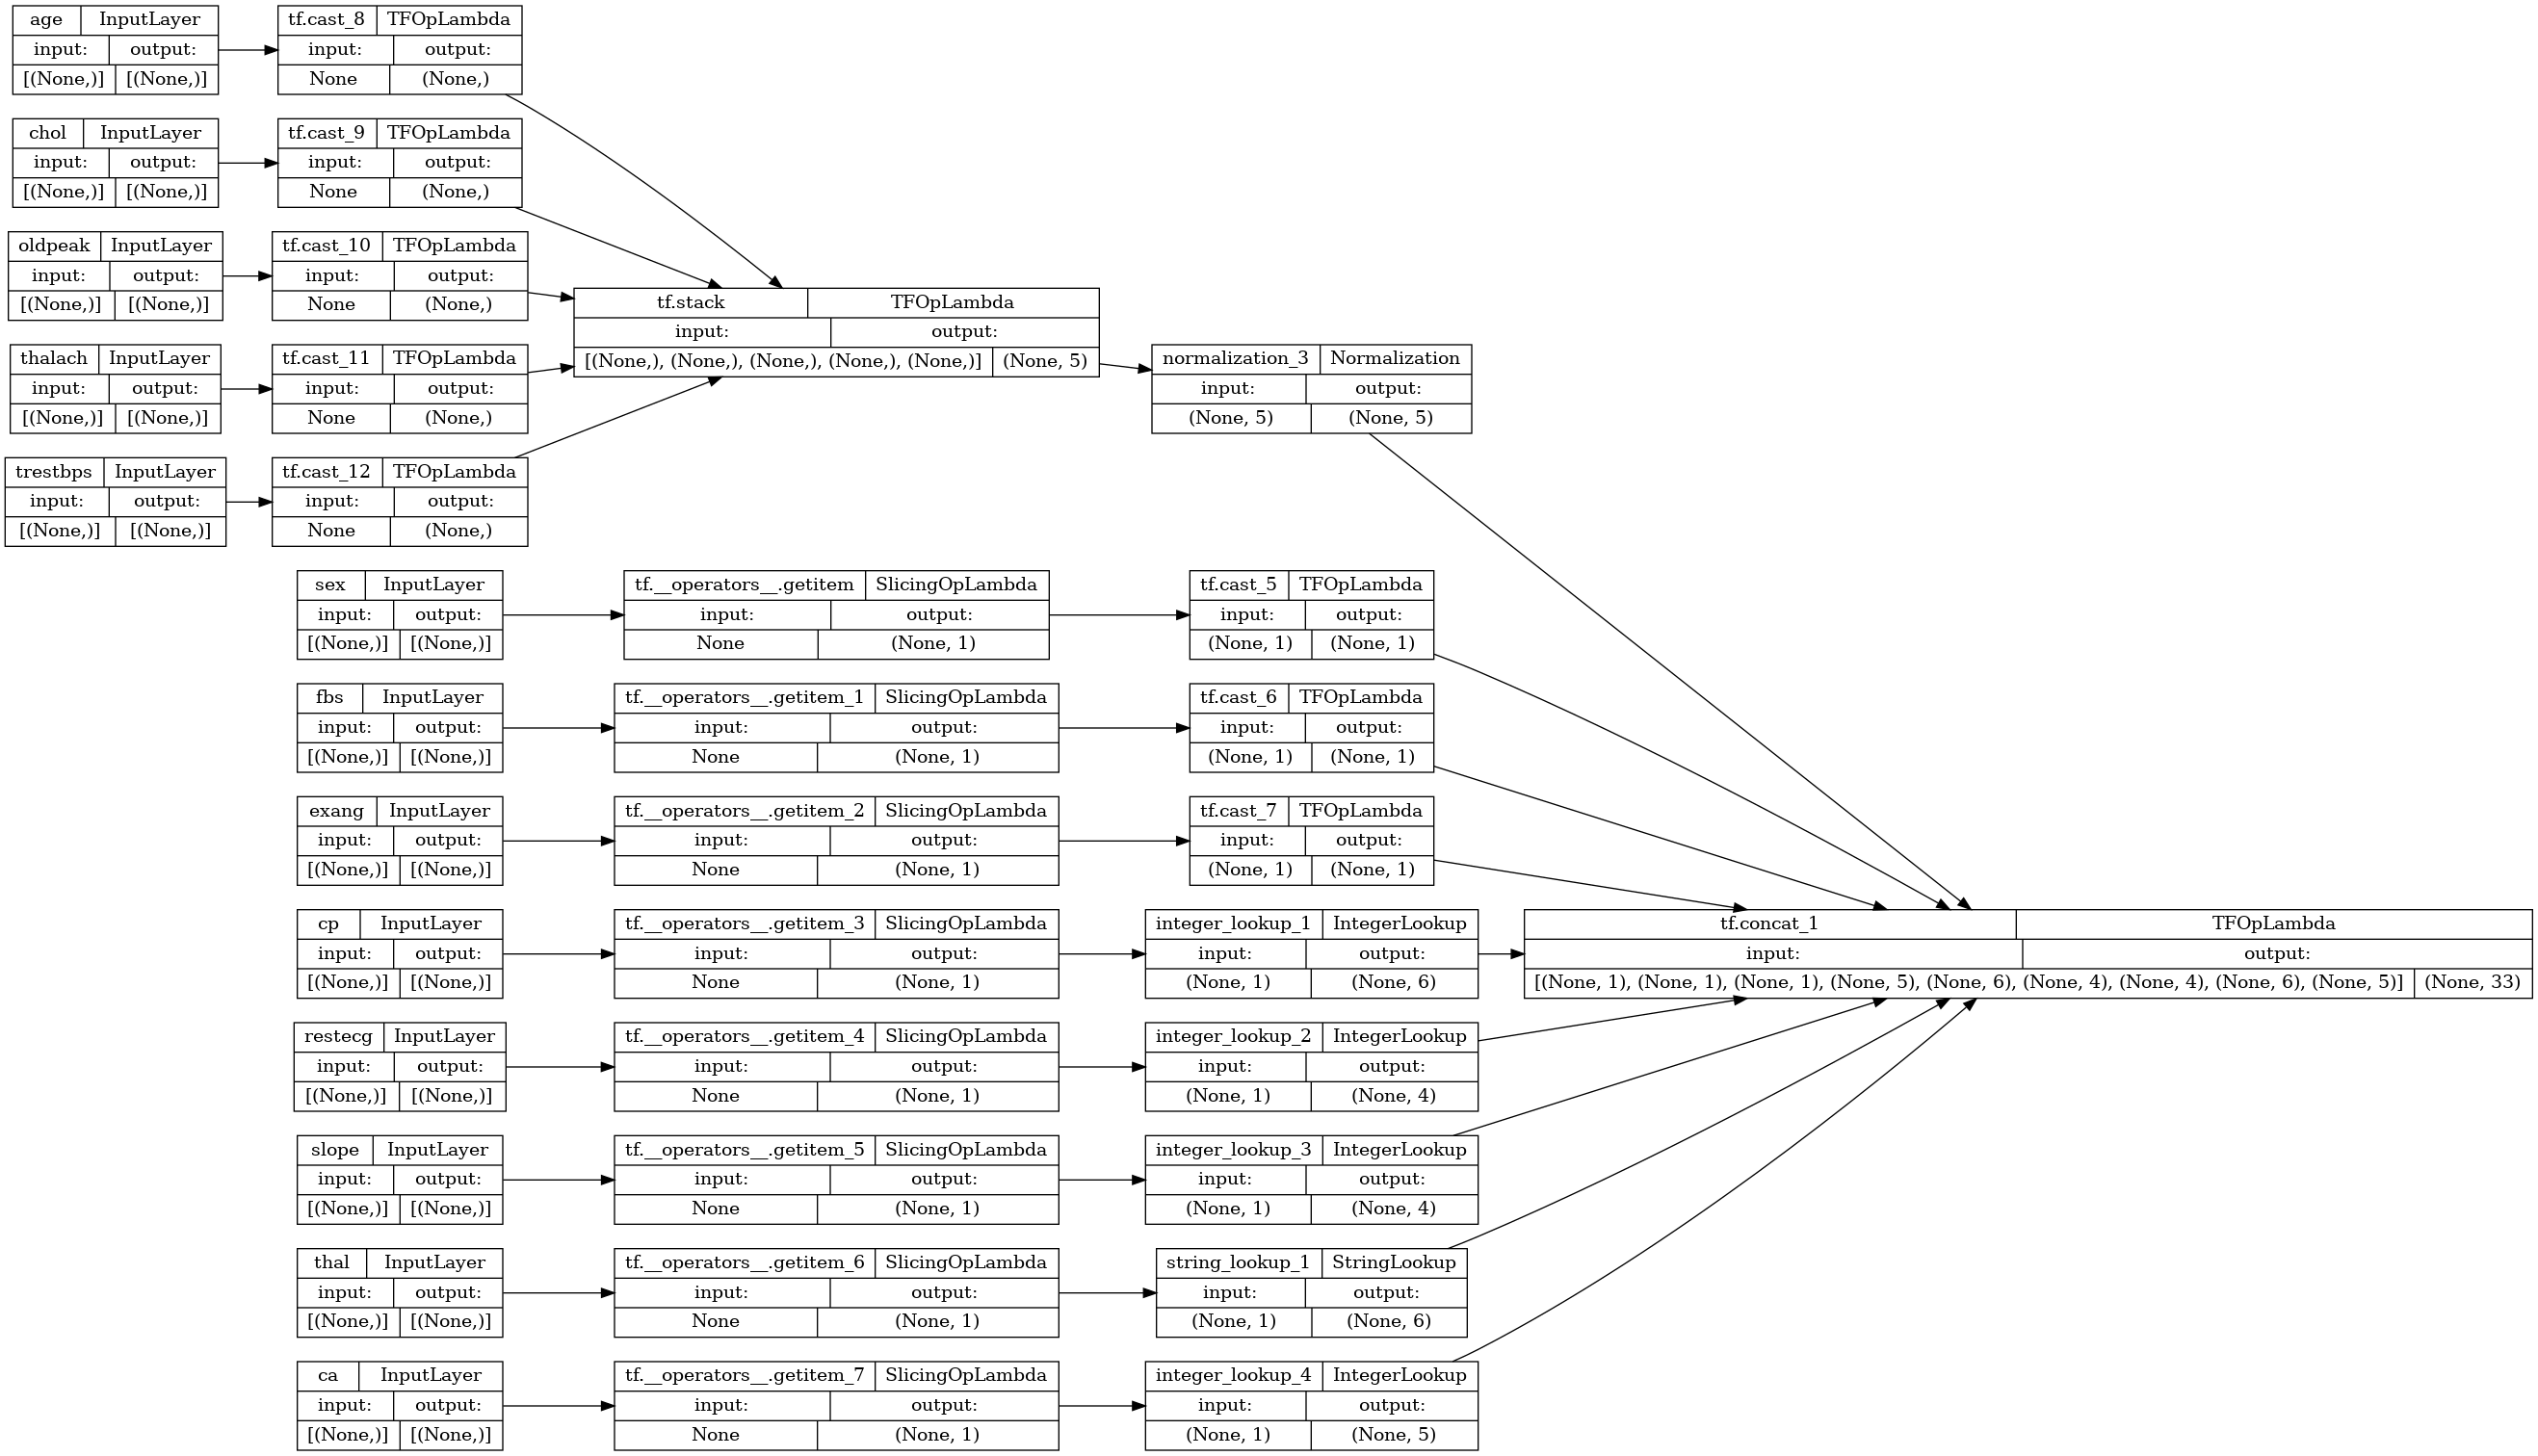

In [ ]:
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

要测试预处理器，请使用 <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html" class="external">DataFrame.iloc</a> 访问器对 DataFrame 中的第一个样本进行切片。然后将它转换为字典并将字典传递给预处理器。结果为包含二元特征、归一化数值特征和独热分类特征的单个向量，按该顺序：

In [ ]:
preprocessor(dict(df.iloc[:1]))

<tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[ 1.        ,  1.        ,  0.        ,  0.93383914, -0.26008663,
         1.0680453 ,  0.03480718,  0.74578077,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ]], dtype=float32)>

### 创建和训练模型

现在，构建模型主体。使用与上一个示例相同的配置：一对 `Dense` 修正线性层和一个 `Dense(1)` 输出层用于分类。

In [ ]:
body = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

现在，使用 Keras 函数式 API 将这两部分结合在一起。

In [ ]:
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

In [ ]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'model_1')>

In [ ]:
result = body(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential_3')>

In [ ]:
model = tf.keras.Model(inputs, result)

model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

此模型需要一个输入字典。将数据传递给它的最简单方式是将 DataFrame 转换为字典并将该字典作为 `x` 参数传递给 `Model.fit`：

In [ ]:
history = model.fit(dict(df), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5



  1/152 [..............................] - ETA: 3:17 - loss: 0.4281 - accuracy: 1.0000


 12/152 [=>............................] - ETA: 0s - loss: 0.5509 - accuracy: 0.7917  


 24/152 [===>..........................] - ETA: 0s - loss: 0.5083 - accuracy: 0.7917


 36/152 [======>.......................] - ETA: 0s - loss: 0.5340 - accuracy: 0.7361


 48/152 [========>.....................] - ETA: 0s - loss: 0.5096 - accuracy: 0.7396


 60/152 [==========>...................] - ETA: 0s - loss: 0.5119 - accuracy: 0.7500


 72/152 [=============>................] - ETA: 0s - loss: 0.5070 - accuracy: 0.7361


 83/152 [===============>..............] - ETA: 0s - loss: 0.4955 - accuracy: 0.7410


 96/152 [=================>............] - ETA: 0s - loss: 0.5005 - accuracy: 0.7344


109/152 [====================>.........] - ETA: 0s - loss: 0.4945 - accuracy: 0.7431


121/152 [======================>.......] - ETA: 0s - loss: 0.4921 - accuracy: 0.7355


133/152 [=========================>....] - ETA: 0s - loss: 0.4997 - accuracy: 0.7331


145/152 [===========================>..] - ETA: 0s - loss: 0.4944 - accuracy: 0.7414


152/152 [==============================] - 2s 4ms/step - loss: 0.4911 - accuracy: 0.7327


Epoch 2/5



  1/152 [..............................] - ETA: 0s - loss: 0.2957 - accuracy: 1.0000


 13/152 [=>............................] - ETA: 0s - loss: 0.3745 - accuracy: 0.7692


 25/152 [===>..........................] - ETA: 0s - loss: 0.4129 - accuracy: 0.7800


 37/152 [======>.......................] - ETA: 0s - loss: 0.4018 - accuracy: 0.7838


 49/152 [========>.....................] - ETA: 0s - loss: 0.4052 - accuracy: 0.7755


 61/152 [===========>..................] - ETA: 0s - loss: 0.4116 - accuracy: 0.7787


 73/152 [=============>................] - ETA: 0s - loss: 0.4326 - accuracy: 0.7397


 86/152 [===============>..............] - ETA: 0s - loss: 0.4558 - accuracy: 0.7384


 98/152 [==================>...........] - ETA: 0s - loss: 0.4389 - accuracy: 0.7551


111/152 [====================>.........] - ETA: 0s - loss: 0.4205 - accuracy: 0.7703


123/152 [=======================>......] - ETA: 0s - loss: 0.4200 - accuracy: 0.7724


135/152 [=========================>....] - ETA: 0s - loss: 0.4062 - accuracy: 0.7778


147/152 [============================>.] - ETA: 0s - loss: 0.4039 - accuracy: 0.7755


152/152 [==============================] - 1s 4ms/step - loss: 0.4004 - accuracy: 0.7789


Epoch 3/5



  1/152 [..............................] - ETA: 0s - loss: 0.1546 - accuracy: 1.0000


 13/152 [=>............................] - ETA: 0s - loss: 0.3017 - accuracy: 0.9231


 25/152 [===>..........................] - ETA: 0s - loss: 0.3022 - accuracy: 0.9000


 37/152 [======>.......................] - ETA: 0s - loss: 0.3108 - accuracy: 0.8649


 49/152 [========>.....................] - ETA: 0s - loss: 0.2933 - accuracy: 0.8673


 61/152 [===========>..................] - ETA: 0s - loss: 0.2817 - accuracy: 0.8770


 73/152 [=============>................] - ETA: 0s - loss: 0.2984 - accuracy: 0.8493


 85/152 [===============>..............] - ETA: 0s - loss: 0.2999 - accuracy: 0.8412


 97/152 [==================>...........] - ETA: 0s - loss: 0.3274 - accuracy: 0.8299


110/152 [====================>.........] - ETA: 0s - loss: 0.3506 - accuracy: 0.8227


122/152 [=======================>......] - ETA: 0s - loss: 0.3495 - accuracy: 0.8279


134/152 [=========================>....] - ETA: 0s - loss: 0.3530 - accuracy: 0.8284


146/152 [===========================>..] - ETA: 0s - loss: 0.3480 - accuracy: 0.8288


152/152 [==============================] - 1s 4ms/step - loss: 0.3546 - accuracy: 0.8218


Epoch 4/5



  1/152 [..............................] - ETA: 0s - loss: 0.1873 - accuracy: 1.0000


 13/152 [=>............................] - ETA: 0s - loss: 0.4305 - accuracy: 0.7308


 25/152 [===>..........................] - ETA: 0s - loss: 0.4172 - accuracy: 0.7600


 37/152 [======>.......................] - ETA: 0s - loss: 0.3618 - accuracy: 0.8108


 49/152 [========>.....................] - ETA: 0s - loss: 0.3613 - accuracy: 0.8367


 61/152 [===========>..................] - ETA: 0s - loss: 0.3695 - accuracy: 0.8361


 73/152 [=============>................] - ETA: 0s - loss: 0.3602 - accuracy: 0.8425


 85/152 [===============>..............] - ETA: 0s - loss: 0.3296 - accuracy: 0.8529


 97/152 [==================>...........] - ETA: 0s - loss: 0.3271 - accuracy: 0.8454


109/152 [====================>.........] - ETA: 0s - loss: 0.3517 - accuracy: 0.8303


121/152 [======================>.......] - ETA: 0s - loss: 0.3306 - accuracy: 0.8430


133/152 [=========================>....] - ETA: 0s - loss: 0.3249 - accuracy: 0.8421


145/152 [===========================>..] - ETA: 0s - loss: 0.3243 - accuracy: 0.8414


152/152 [==============================] - 1s 4ms/step - loss: 0.3270 - accuracy: 0.8383


Epoch 5/5



  1/152 [..............................] - ETA: 0s - loss: 0.7382 - accuracy: 0.5000


 13/152 [=>............................] - ETA: 0s - loss: 0.3586 - accuracy: 0.8077


 25/152 [===>..........................] - ETA: 0s - loss: 0.2828 - accuracy: 0.8400


 37/152 [======>.......................] - ETA: 0s - loss: 0.2441 - accuracy: 0.8649


 49/152 [========>.....................] - ETA: 0s - loss: 0.2572 - accuracy: 0.8469


 61/152 [===========>..................] - ETA: 0s - loss: 0.2873 - accuracy: 0.8279


 73/152 [=============>................] - ETA: 0s - loss: 0.2904 - accuracy: 0.8356


 85/152 [===============>..............] - ETA: 0s - loss: 0.3007 - accuracy: 0.8294


 97/152 [==================>...........] - ETA: 0s - loss: 0.2946 - accuracy: 0.8299


109/152 [====================>.........] - ETA: 0s - loss: 0.2938 - accuracy: 0.8394


122/152 [=======================>......] - ETA: 0s - loss: 0.2907 - accuracy: 0.8484


134/152 [=========================>....] - ETA: 0s - loss: 0.2950 - accuracy: 0.8433


146/152 [===========================>..] - ETA: 0s - loss: 0.2949 - accuracy: 0.8425


152/152 [==============================] - 1s 4ms/step - loss: 0.3083 - accuracy: 0.8350


也可以使用 `tf.data`：

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((
    dict(df),
    target
))

ds = ds.batch(BATCH_SIZE)

In [ ]:
import pprint

for x, y in ds.take(1):
  pprint.pprint(x)
  print()
  print(y)

{'age': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([63, 67])>,
 'ca': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 3])>,
 'chol': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([233, 286])>,
 'cp': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 4])>,
 'exang': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>,
 'fbs': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>,
 'oldpeak': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.3, 1.5])>,
 'restecg': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 2])>,
 'sex': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1])>,
 'slope': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 2])>,
 'thal': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'fixed', b'normal'], dtype=object)>,
 'thalach': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([150, 108])>,
 'trestbps': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([145, 160])>}

tf.Tensor([0 1], shape=(2,), dtype=int64)


In [ ]:
history = model.fit(ds, epochs=5)

Epoch 1/5



  1/152 [..............................] - ETA: 1:02 - loss: 0.3983 - accuracy: 1.0000


 12/152 [=>............................] - ETA: 0s - loss: 0.2682 - accuracy: 0.8333  


 24/152 [===>..........................] - ETA: 0s - loss: 0.2876 - accuracy: 0.8333


 37/152 [======>.......................] - ETA: 0s - loss: 0.2756 - accuracy: 0.8243


 49/152 [========>.....................] - ETA: 0s - loss: 0.2420 - accuracy: 0.8571


 61/152 [===========>..................] - ETA: 0s - loss: 0.2420 - accuracy: 0.8689


 73/152 [=============>................] - ETA: 0s - loss: 0.2728 - accuracy: 0.8425


 85/152 [===============>..............] - ETA: 0s - loss: 0.2553 - accuracy: 0.8471


 97/152 [==================>...........] - ETA: 0s - loss: 0.2731 - accuracy: 0.8351


109/152 [====================>.........] - ETA: 0s - loss: 0.2907 - accuracy: 0.8211


121/152 [======================>.......] - ETA: 0s - loss: 0.2817 - accuracy: 0.8306


133/152 [=========================>....] - ETA: 0s - loss: 0.2836 - accuracy: 0.8421


145/152 [===========================>..] - ETA: 0s - loss: 0.2859 - accuracy: 0.8414


152/152 [==============================] - 1s 4ms/step - loss: 0.2946 - accuracy: 0.8383


Epoch 2/5



  1/152 [..............................] - ETA: 0s - loss: 0.3869 - accuracy: 1.0000


 13/152 [=>............................] - ETA: 0s - loss: 0.2422 - accuracy: 0.8462


 25/152 [===>..........................] - ETA: 0s - loss: 0.2712 - accuracy: 0.8600


 37/152 [======>.......................] - ETA: 0s - loss: 0.2701 - accuracy: 0.8378


 49/152 [========>.....................] - ETA: 0s - loss: 0.2378 - accuracy: 0.8673


 61/152 [===========>..................] - ETA: 0s - loss: 0.2367 - accuracy: 0.8770


 73/152 [=============>................] - ETA: 0s - loss: 0.2651 - accuracy: 0.8493


 85/152 [===============>..............] - ETA: 0s - loss: 0.2469 - accuracy: 0.8529


 97/152 [==================>...........] - ETA: 0s - loss: 0.2638 - accuracy: 0.8402


109/152 [====================>.........] - ETA: 0s - loss: 0.2811 - accuracy: 0.8303


122/152 [=======================>......] - ETA: 0s - loss: 0.2721 - accuracy: 0.8402


135/152 [=========================>....] - ETA: 0s - loss: 0.2801 - accuracy: 0.8444


148/152 [============================>.] - ETA: 0s - loss: 0.2804 - accuracy: 0.8480


152/152 [==============================] - 1s 4ms/step - loss: 0.2832 - accuracy: 0.8515


Epoch 3/5



  1/152 [..............................] - ETA: 0s - loss: 0.3545 - accuracy: 1.0000


 13/152 [=>............................] - ETA: 0s - loss: 0.2318 - accuracy: 0.8846


 25/152 [===>..........................] - ETA: 0s - loss: 0.2636 - accuracy: 0.8800


 37/152 [======>.......................] - ETA: 0s - loss: 0.2643 - accuracy: 0.8514


 49/152 [========>.....................] - ETA: 0s - loss: 0.2329 - accuracy: 0.8673


 61/152 [===========>..................] - ETA: 0s - loss: 0.2315 - accuracy: 0.8770


 73/152 [=============>................] - ETA: 0s - loss: 0.2579 - accuracy: 0.8562


 85/152 [===============>..............] - ETA: 0s - loss: 0.2397 - accuracy: 0.8588


 98/152 [==================>...........] - ETA: 0s - loss: 0.2630 - accuracy: 0.8418


110/152 [====================>.........] - ETA: 0s - loss: 0.2716 - accuracy: 0.8409


122/152 [=======================>......] - ETA: 0s - loss: 0.2636 - accuracy: 0.8484


134/152 [=========================>....] - ETA: 0s - loss: 0.2711 - accuracy: 0.8507


146/152 [===========================>..] - ETA: 0s - loss: 0.2656 - accuracy: 0.8562


152/152 [==============================] - 1s 4ms/step - loss: 0.2742 - accuracy: 0.8548


Epoch 4/5



  1/152 [..............................] - ETA: 0s - loss: 0.3332 - accuracy: 1.0000


 13/152 [=>............................] - ETA: 0s - loss: 0.2235 - accuracy: 0.8846


 25/152 [===>..........................] - ETA: 0s - loss: 0.2565 - accuracy: 0.8800


 37/152 [======>.......................] - ETA: 0s - loss: 0.2582 - accuracy: 0.8514


 49/152 [========>.....................] - ETA: 0s - loss: 0.2274 - accuracy: 0.8673


 61/152 [===========>..................] - ETA: 0s - loss: 0.2253 - accuracy: 0.8770


 73/152 [=============>................] - ETA: 0s - loss: 0.2507 - accuracy: 0.8630


 85/152 [===============>..............] - ETA: 0s - loss: 0.2329 - accuracy: 0.8647


 97/152 [==================>...........] - ETA: 0s - loss: 0.2488 - accuracy: 0.8505


109/152 [====================>.........] - ETA: 0s - loss: 0.2655 - accuracy: 0.8394


122/152 [=======================>......] - ETA: 0s - loss: 0.2560 - accuracy: 0.8484


135/152 [=========================>....] - ETA: 0s - loss: 0.2633 - accuracy: 0.8519


147/152 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.8537


152/152 [==============================] - 1s 4ms/step - loss: 0.2663 - accuracy: 0.8548


Epoch 5/5



  1/152 [..............................] - ETA: 0s - loss: 0.3224 - accuracy: 1.0000


 13/152 [=>............................] - ETA: 0s - loss: 0.2181 - accuracy: 0.9231


 25/152 [===>..........................] - ETA: 0s - loss: 0.2519 - accuracy: 0.9000


 37/152 [======>.......................] - ETA: 0s - loss: 0.2554 - accuracy: 0.8649


 48/152 [========>.....................] - ETA: 0s - loss: 0.2302 - accuracy: 0.8750


 60/152 [==========>...................] - ETA: 0s - loss: 0.2252 - accuracy: 0.8833


 72/152 [=============>................] - ETA: 0s - loss: 0.2500 - accuracy: 0.8681


 84/152 [===============>..............] - ETA: 0s - loss: 0.2315 - accuracy: 0.8750


 96/152 [=================>............] - ETA: 0s - loss: 0.2297 - accuracy: 0.8698


108/152 [====================>.........] - ETA: 0s - loss: 0.2565 - accuracy: 0.8565


120/152 [======================>.......] - ETA: 0s - loss: 0.2503 - accuracy: 0.8625


132/152 [=========================>....] - ETA: 0s - loss: 0.2425 - accuracy: 0.8750


144/152 [===========================>..] - ETA: 0s - loss: 0.2532 - accuracy: 0.8681


152/152 [==============================] - 1s 4ms/step - loss: 0.2596 - accuracy: 0.8680
